In [1]:
import os
import sys
import numpy as np
import pandas as pd

from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import History
import matplotlib.pyplot as plt
import preprocessor as p
from nltk.stem import PorterStemmer
import re
import RBMFuncs
from importlib import reload
reload(RBMFuncs)

ImportError: No module named keras.layers

In [94]:
data = pd.read_csv('train_validation_set_withScores.csv' , encoding = 'utf-8')
#data = data[data.dummy == 1]
emoDict = {'anger' : 0 , 'fear' : 1 , 'joy': 2 , 'sadness' : 3}
labels = [] #initializing
for emo in data.emotion:
    labels.append(emoDict.get(emo))
    
labels = np.array(labels) #Save it as an array
    
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = data.text

# p.set_options(p.OPT.URL, p.OPT.RESERVED, p.OPT.MENTION)
# text = p.clean(text).lower()
def clean_text(raw_text):
    text = raw_text#.encode('b')
    useReplaceDict = {"don't" : "do not", "can't" : "can not", "doesn't" : "does not", "hasn't": "has not", 
            "haven't" : "have not", "hadn't" : "had not", "couldn't" : "could not", "wasn't" : "was not", "didn't": "did not",
             "weren't" : "were not", "wouldn't": "would not", "won't" : "would not", "shouldn't": "should not", 
            "don't": "do not", "it's" : "it is", "he's" : "he is", "she's" : "she is", "i'm" : "i am", "i've" : "i have", 
            "they've": "they have", "you've" : "you have", "we've": "we have", "ppl" : "people", "we're" : "we are", 
            "i'll": "i will" , "they're" : "they are", "he'll" : "he will", "she'll" : "she will", "we'll" : "we will" ,
            "they'll":"they will", "you'll" : "you will", "w/o" : "without out", "i'd" : "i would"}
    from nltk.corpus import stopwords
    nltk_stop_words = set(stopwords.words('english'))
    #text = " ".join([x for x in text.split("\n")]) #Joins new lines with spaces
    text = text.replace("\n"," ").replace("\r"," ").replace("#"," ").lower()
    text = re.sub(r"https\S+", "LINK", text)
    text = text.replace("&amp;", "and")
    text = re.sub(r'/', ' or ', text)
    text = re.sub(r'@\S+', 'MENTION',text)
    text = re.sub(r'[",:.\-;()|+&=!/?#$@\[\]]+', ' ', text)
    #text = re.sub(r'www.+' , '' , text)
    replaced_text = ""
    rep_text = useReplaceDict
    if useReplaceDict:
        for term in text.split():
            if term.strip() != '' and term.strip() in rep_text.keys():
                replaced_text += rep_text[term] + " "
            else:
                replaced_text += term + " "    
        text = replaced_text
    text = " ".join([x for x in text.split() if x.strip() not in nltk_stop_words])
    text = re.sub(r'[",:.\-;()|+&=!?#$@\[\]]+', ' ', text)
#     print replaced_text
    return text#.encode("utf-8")
    
texts = texts.apply(clean_text)

In [95]:
# Variables used in the next cell
MAX_NB_WORDS = 7000 #Max number of words to be used in the embedding
VALIDATION_SPLIT = .05 #validation split during the fitting of the model
sequence_length = 30
EMBEDDING_DIM = 200 #set later

In [96]:
X = pd.Series(texts , index = data.index)
y = pd.Series(labels , index = data.index)
#X_train_words, X_test_words, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [97]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(X) #actually converting the words in text to integers
word_index = tokenizer.word_index #This is a dictionary {}
print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = sequence_length #pad the tweet length to 30
X = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH , value = 0)

Found 9438 unique tokens.


In [107]:
vocabulary_size

9439

In [98]:
#This is very time consuming, do not run again and againS
GLOVE_DIR = '/emdedding/'
embeddings_index = {} #dictionary keys - words and values are the 100 dimension vector
f = open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt')  , encoding="utf8")
for line in f:
    values = line.split() #each line in the glove text file
    word = values[0] #The thing on the 0th position is the word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [99]:
# assemble the embedding_weights in one numpy array
vocab_dim = EMBEDDING_DIM # dimensionality of your word vectors
n_symbols = len(word_index) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, vocab_dim))
for word,index in word_index.items():
    try:
        embedding_weights[index, :] = embeddings_index[word]
    except KeyError:
        embedding_weights[index, :] = np.random.randn(1,EMBEDDING_DIM)

In [110]:
#sequence_length = X_train.shape[1] #The padded length of the tweet which is MAX_SEQUENCE_LENGTH
vocabulary_size = len(word_index) + 1 # 11559 Total number of words, (why did this not change after cleaning)
#embedding_dim = 200 #Length of the word vector that I want after embedding
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.3 #Increased from .5 because my model was overfitting a little
epochs = 30
batch_size = 256

In [111]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y)#keras take an input in this form

In [118]:
sequence_length - filter_sizes[1] + 1, 1

(27, 1)

In [113]:
from keras.regularizers import l2

inputs = Input(shape=(sequence_length,), dtype='int32')
#embedding = Embedding(input_dim = vocabulary_size, output_dim = embedding_dim, input_length = sequence_length)(inputs)
#output shape of reshape is (None , 30 , 100 , 1)
embedding_layer = Embedding(output_dim=vocab_dim ,  input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])
embedded = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedded)


embedding = Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIM, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1 , maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("Training Model...")
history = History() #Helps store the errors during all epochs
model.fit(X_train, dummy_y_train, batch_size=256, epochs=epochs, )  # starts training

Training Model...
Epoch 1/30
2653/2653 [==============================] - 17s 6ms/step - loss: 1.3544 - acc: 0.3389
Epoch 2/30
2653/2653 [==============================] - 15s 6ms/step - loss: 1.1810 - acc: 0.5149
Epoch 3/30
2653/2653 [==============================] - 16s 6ms/step - loss: 0.9123 - acc: 0.8564
Epoch 4/30
2653/2653 [==============================] - 15s 6ms/step - loss: 0.4895 - acc: 0.9600
Epoch 5/30
2653/2653 [==============================] - 15s 6ms/step - loss: 0.1728 - acc: 0.9736
Epoch 6/30
2653/2653 [==============================] - 16s 6ms/step - loss: 0.0668 - acc: 0.9838
Epoch 7/30
2653/2653 [==============================] - 16s 6ms/step - loss: 0.0390 - acc: 0.9879
Epoch 8/30
2653/2653 [==============================] - 15s 6ms/step - loss: 0.0292 - acc: 0.9902
Epoch 9/30
2653/2653 [==============================] - 15s 6ms/step - loss: 0.0267 - acc: 0.9887
Epoch 10/30
2653/2653 [==============================] - 15s 6ms/step - loss: 0.0258 - acc: 0.9879
E

In [114]:
from keras.models import load_model
model.save('EmotionCNN30March-Overfitting.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('EmotionCNN30March-Overfitting.h5')

# Hyperparameter tuning

- https://towardsdatascience.com/a-walkthrough-of-convolutional-neural-network-7f474f91d7bd
- Optimal number of **epochs** - After 20, the model starts overfitting
- Good default settings for the tested machine learning problems are alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8

## Prediction

In [115]:
y_prob = model.predict(X_test) 
y_pred = y_prob.argmax(axis=-1)
y_actual = [y for y in y_test]

from sklearn.metrics import accuracy_score
score = accuracy_score(y_true = y_actual , y_pred = y_pred )
print("The accuracy score is : " + str(round(score , 3) * 100) + "%")

The accuracy score is : 86.6%


Confusion matrix, without normalization
[[277  19   9  25]
 [ 13 369  11  32]
 [  8   4 271   6]
 [ 10  28  10 215]]


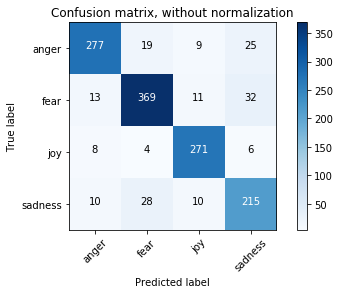

In [116]:
y_pred_test = model.predict(X_test).argmax(axis = -1)
predDfTest = pd.DataFrame({'Actual' : y_test , 'Predicted' : y_pred_test})
#valDf = predDf.tail(266)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(predDfTest.Actual, predDfTest.Predicted)
np.set_printoptions(precision=2)
plt.figure()
class_names = np.array(['anger' , 'fear' ,'joy' , 'sadness'])
RBMFuncs.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [184]:
emoDictReverse = {0 : 'anger' , 1 : 'fear' , 2 : 'joy' , 3 : 'sadness'}

predictedLabels = [] #initializing
for emo in y_pred:
    predictedLabels.append(emoDictReverse.get(emo))
    
actualLabels = [] #Initializing
for emo in y_actual:
    actualLabels.append(emoDictReverse.get(emo))
    
predictedLabels = pd.Series(predictedLabels , index = X_test_words.index)
actualLabels = pd.Series(actualLabels , index = X_test_words.index)

#Converting the final thing into a Data frame
predictedDf = pd.concat([X_test_words, predictedLabels, actualLabels], axis=1)
predictedDf.columns = ['Tweet' , 'EmotionPredicted' , 'Emotion Actual']

In [185]:
predictedDf.to_csv('predicted29March.csv')

## References
- https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
- https://github.com/s/preprocessor - preprocessor documentation